# Proyek Klasifikasi Gambar: KITTI Object Detection

Notebook ini mencakup pipeline lengkap untuk melatih klasifikasi gambar 'Car', 'Pedestrian', 'Cyclist', dan 'Van' menggunakan dataset KITTI.

**Fitur:**
1.  **Data Loading & Augmentation**: Menggunakan `ImageDataGenerator`.
2.  **Model Architecture**: Sequential CNN dengan `Conv2D` dan `MaxPooling`.
3.  **Training**: Menggunakan Callbacks (`EarlyStopping`, `ModelCheckpoint`).
4.  **Evaluation**: Plot Akurasi dan Loss.
5.  **Inference**: Uji coba prediksi pada data baru.
6.  **Model Conversion**: Konversi ke SavedModel, TF-Lite, dan TFJS.

---

## 1. Import Library & Konfigurasi

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

# Konfigurasi Path
BASE_DIR = 'data_split'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameter Gambar
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
TARGET_SIZE = (IMG_HEIGHT, IMG_WIDTH)

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


## 2. Data Preparation (Augmentation)

In [2]:
# Augmentasi untuk data Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation hanya di-rescale
validation_datagen = ImageDataGenerator(rescale=1./255)

print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical' # Multiclass (Kriteria: Dataset Splitting)
)

print("Loading Validation Data...")
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


print("Loading Test Data...")
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


print("Loading Test Data...")
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


print("Loading Test Data...")
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

CLASSES = list(train_generator.class_indices.keys())
print(f"Classes: {CLASSES}")

Loading Training Data...
Found 8934 images belonging to 4 classes.
Loading Validation Data...
Found 1115 images belonging to 4 classes.
Loading Test Data...
Found 1120 images belonging to 4 classes.
Loading Test Data...
Found 1120 images belonging to 4 classes.
Loading Test Data...
Found 1120 images belonging to 4 classes.
Classes: ['car', 'cyclist', 'pedestrian', 'van']


## 3. Membangun Arsitektur Model (CNN)

In [3]:
model = Sequential([ # Kriteria: Model Sequential CNN
    tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    # Conv Block 1
    Conv2D(32, (3, 3), activation='relu'), # Kriteria: Conv2D Layer
    MaxPooling2D(2, 2), # Kriteria: MaxPooling Layer
    
    # Conv Block 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), # Kriteria: MaxPooling Layer
    
    # Conv Block 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), # Kriteria: MaxPooling Layer
    
    # Flatten & Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    # Output Layer (4 Kelas: Car, Cyclist, Pedestrian, Van)
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,035,716 (72.62 MB)

 Trainable params: 19,035,716 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Training (Dengan Callbacks)

In [4]:
# Callbacks
callbacks = [
    # Hentikan training jika val_accuracy tidak naik selama 5 epochs
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True), # Kriteria: Accuracy > 85% monitored
    # Simpan model terbaik
    tf.keras.callbacks.ModelCheckpoint('saved_model/model_best.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("Starting Training...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)

Starting Training...
Epoch 1/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7894 - loss: 0.7226
Epoch 1: val_accuracy improved from None to 0.88695, saving model to saved_model/model_best.h5



Epoch 1: finished saving model to saved_model/model_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 47s 166ms/step - accuracy: 0.8178 - loss: 0.5618 - val_accuracy: 0.8869 - val_loss: 0.3401
Epoch 2/10
  1/279 ━━━━━━━━━━━━━━━━━━━━ 47s 171ms/step - accuracy: 0.8125 - loss: 0.5280
Epoch 2: val_accuracy did not improve from 0.88695
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8125 - loss: 0.5280 - val_accuracy: 0.8842 - val_loss: 0.3345
Epoch 3/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8710 - loss: 0.3978
Epoch 3: val_accuracy improved from 0.88695 to 0.90625, saving model to saved_model/model_best.h5



Epoch 3: finished saving model to saved_model/model_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 46s 166ms/step - accuracy: 0.8704 - loss: 0.3848 - val_accuracy: 0.9062 - val_loss: 0.2630
Epoch 4/10
  1/279 ━━━━━━━━━━━━━━━━━━━━ 44s 158ms/step - accuracy: 0.7500 - loss: 0.5313
Epoch 4: val_accuracy improved from 0.90625 to 0.90809, saving model to saved_model/model_best.h5



Epoch 4: finished saving model to saved_model/model_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7500 - loss: 0.5313 - val_accuracy: 0.9081 - val_loss: 0.2619
Epoch 5/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8841 - loss: 0.3234
Epoch 5: val_accuracy did not improve from 0.90809
279/279 ━━━━━━━━━━━━━━━━━━━━ 46s 164ms/step - accuracy: 0.8913 - loss: 0.3136 - val_accuracy: 0.9062 - val_loss: 0.2354
Epoch 6/10
  1/279 ━━━━━━━━━━━━━━━━━━━━ 43s 157ms/step - accuracy: 0.8125 - loss: 0.4446
Epoch 6: val_accuracy improved from 0.90809 to 0.90993, saving model to saved_model/model_best.h5



Epoch 6: finished saving model to saved_model/model_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8125 - loss: 0.4446 - val_accuracy: 0.9099 - val_loss: 0.2309
Epoch 7/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8905 - loss: 0.3035
Epoch 7: val_accuracy improved from 0.90993 to 0.93107, saving model to saved_model/model_best.h5



Epoch 7: finished saving model to saved_model/model_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 47s 169ms/step - accuracy: 0.8964 - loss: 0.2920 - val_accuracy: 0.9311 - val_loss: 0.1974
Epoch 8/10
  1/279 ━━━━━━━━━━━━━━━━━━━━ 43s 157ms/step - accuracy: 0.7500 - loss: 0.5790
Epoch 8: val_accuracy did not improve from 0.93107
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7500 - loss: 0.5790 - val_accuracy: 0.9311 - val_loss: 0.1992
Epoch 9/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9013 - loss: 0.2657
Epoch 9: val_accuracy improved from 0.93107 to 0.94577, saving model to saved_model/model_best.h5



Epoch 9: finished saving model to saved_model/model_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 46s 164ms/step - accuracy: 0.9056 - loss: 0.2580 - val_accuracy: 0.9458 - val_loss: 0.1592
Epoch 10/10
  1/279 ━━━━━━━━━━━━━━━━━━━━ 42s 154ms/step - accuracy: 0.9375 - loss: 0.2949
Epoch 10: val_accuracy improved from 0.94577 to 0.94853, saving model to saved_model/model_best.h5



Epoch 10: finished saving model to saved_model/model_best.h5
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9375 - loss: 0.2949 - val_accuracy: 0.9485 - val_loss: 0.1551


## 5. Evaluasi & Visualisasi

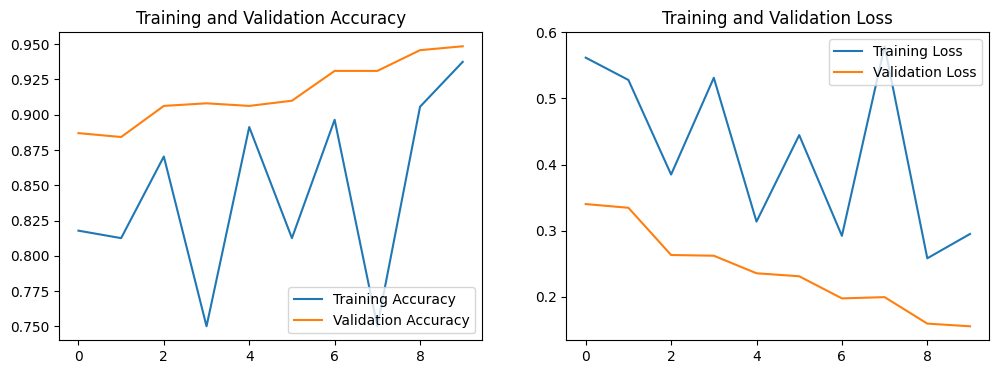

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy') # Kriteria: Plot Accuracy & Loss
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

## 6. Inference (Uji Coba)
Mengambil satu gambar acak dari folder test.

Evaluating on Test Set...
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9527 - loss: 0.1300
Test Loss: 0.12996578216552734
Test Accuracy: 95.27%
Kriteria Terpenuhi: Akurasi pada Test Set >= 85%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
True Label: car
Predicted: car


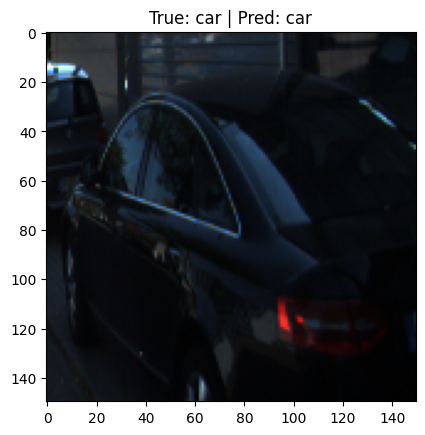

In [6]:
# Evaluasi Model pada Data Test
print("Evaluating on Test Set...")
if 'test_generator' in locals():
    results = model.evaluate(test_generator)
    print(f"Test Loss: {results[0]}")
    print(f"Test Accuracy: {results[1]*100:.2f}%")
    
    if results[1] >= 0.85:
        print("Kriteria Terpenuhi: Akurasi pada Test Set >= 85%")
    else:
        print("Peringatan: Akurasi pada Test Set < 85%")
else:
    print("Test generator not found. Run data loading cell first.")

# Inference pada satu gambar (Demo)
try:
    # Ambil satu batch dari test generator
    x_test_batch, y_test_batch = next(test_generator)
    # Ambil gambar pertama
    img_array = x_test_batch[0]
    true_label_idx = np.argmax(y_test_batch[0])
    
    # Predict
    prediction = model.predict(np.expand_dims(img_array, axis=0))
    predicted_class_idx = np.argmax(prediction, axis=1)[0]
    
    print(f"True Label: {CLASSES[true_label_idx]}")
    print(f"Predicted: {CLASSES[predicted_class_idx]}")
    
    plt.imshow(img_array)
    plt.title(f"True: {CLASSES[true_label_idx]} | Pred: {CLASSES[predicted_class_idx]}")
    plt.show()
except Exception as e:
    print(f"Inference demo error: {e}")


## 7. Konversi Model (SavedModel, TF-Lite, TFJS)

In [7]:
# 1. Simpan Model dalam format SavedModel/H5
# Model sudah tersimpan sebagai model_best.h5 dari callback
# Simpan juga dalam format SavedModel
try:
    model.export('saved_model')  # TF 2.16+
except:
    model.save('saved_model')  # Older Keras/TF
print("Model saved in SavedModel format.")

# 2. Convert to TensorFlow Lite
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open('model.tflite', 'wb') as f:
        f.write(tflite_model)
    print("Model converted to TensorFlow Lite format (model.tflite).")
except Exception as e:
    print(f"Error converting to TensorFlow Lite: {e}")

# 3. Convert to TensorFlow.js
try:
    # Gunakan command line tool via shell command
    !tensorflowjs_converter --input_format=keras saved_model/model_best.h5 tfjs_model
    print("Model converted to TensorFlow.js format (tfjs_model/).")
except Exception as e:
    print(f"Error converting to TFJS: {e}")


INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  5135734864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5135735632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5135736976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5135733136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5135736400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5135737744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5135734288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5135736016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5135737552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5135738704: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model saved in SavedModel format.
INFO:tensorflow:Assets written to: /v

INFO:tensorflow:Assets written to: /var/folders/x9/c7ht26yd67vg2m1jh9ql04rc0000gn/T/tmp0o1cajkn/assets


Saved artifact at '/var/folders/x9/c7ht26yd67vg2m1jh9ql04rc0000gn/T/tmp0o1cajkn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  5135734864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5135735632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5135736976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5135733136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5135736400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5135737744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5135734288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5135736016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5135737552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5135738704: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1768899150.771106 3551604 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1768899150.771119 3551604 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1768899150.774688 3551604 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


Model converted to TensorFlow Lite format (model.tflite).
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
/Users/robin/Documents/mqr-pro/Dicoding/muhammad_muqorrobin_proyek_klasifikasi_gambar/venv/lib/python3.12/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
failed to lookup keras version from the file,
    this is likely a weight only file
Model converted to TensorFlow.js format (tfjs_model/).
